# Simulating Stock Price Paths Using Geometric Brownian Motion

## Overview

This notebook implements a Monte Carlo simulation to generate multiple possible future stock price paths using **Geometric Brownian Motion (GBM)**. GBM is the foundational model in quantitative finance for simulating stock prices and is widely used in derivatives pricing, risk management, and portfolio analysis.

### Key Concepts

- **Geometric Brownian Motion (GBM)**: A continuous-time stochastic process describing the evolution of stock prices
- **Drift (μ)**: The expected return or trend component (8% per year)
- **Volatility (σ)**: The standard deviation of returns representing price fluctuations (20% per year)
- **Monte Carlo Simulation**: A computational technique for valuation and risk assessment using random sampling
- **European Call Option**: An option with payoff $\max(S_T - K, 0)$ at maturity $T$

---

## Mathematical Framework

### The GBM Equation

The continuous-time process is governed by:

$$dS_t = \mu S_t dt + \sigma S_t dW_t$$

where:
- $S_t$ = Stock price at time $t$
- $\mu$ = Drift coefficient (expected return)
- $\sigma$ = Volatility (standard deviation of returns)
- $dW_t$ = Increment of a Wiener process

### Discrete Implementation

For numerical simulation over a time step $\Delta t$:

$$S_{t+\Delta t} = S_t \exp\left[\left(\mu - \frac{\sigma^2}{2}\right)\Delta t + \sigma \sqrt{\Delta t} Z\right]$$

where $Z \sim \mathcal{N}(0,1)$ is a standard normal random variable.

### Theoretical Statistics

After time $T$, the expected value and standard deviation are:

$$\mathbb{E}[S_T] = S_0 e^{\mu T}$$

$$\sigma[S_T] = S_0 e^{\mu T} \sqrt{e^{\sigma^2 T} - 1}$$

---

## Implementation Parameters

We define the simulation parameters as follows:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


### Configuration Parameters

The following parameters define our simulation environment:

In [2]:
# Drift coefficient (expected annual return)
mu = 0.08

# Number of time steps (trading days in a year)
n = 252

# Total time horizon in years
T = 1

# Number of independent simulations (paths)
M = 1000

# Initial stock price
S0 = 100

# Volatility (annual standard deviation of returns)
sigma = 0.20

## Core Simulation Logic

### Step 1: Generate Random Increments

We generate random Wiener process increments using a standard normal distribution. The key insight is that for a time step $\Delta t = 1/252$, we generate random numbers with standard deviation $\sqrt{\Delta t}$ to ensure correct scaling of the stochastic component.

In [3]:
# Calculate time step
dt = T / n

# Generate stochastic increments (simulations x time steps)
# np.random.normal(0, sqrt(dt), size=(M, n)) creates M simulations of n steps
# The .T (transpose) ensures proper axis alignment for path construction
St = np.exp(
    (mu - (sigma**2) / 2) * dt +
    sigma * np.random.normal(0, np.sqrt(dt), size=(M, n)).T
)

# Prepend 1s for the initial condition (price multiplier at t=0)
St = np.vstack([np.ones(M), St])

# Compute cumulative product along each path (axis=0)
# This transforms log-returns into actual prices
St = S0 * St.cumprod(axis=0)

### Step 2: Construct Time Grid

We create a time grid that aligns with our price paths for proper visualization and analysis.

In [4]:
# Define time points from 0 to T
time = np.linspace(0, T, n + 1)

# Create 2D time array matching the shape of St (repeated for each simulation)
tt = np.full(shape=(M, n + 1), fill_value=time).T

## Visualization: Price Paths

The following plot shows all 1000 simulated price paths. This "fan" of paths represents the range of possible futures under the GBM model.

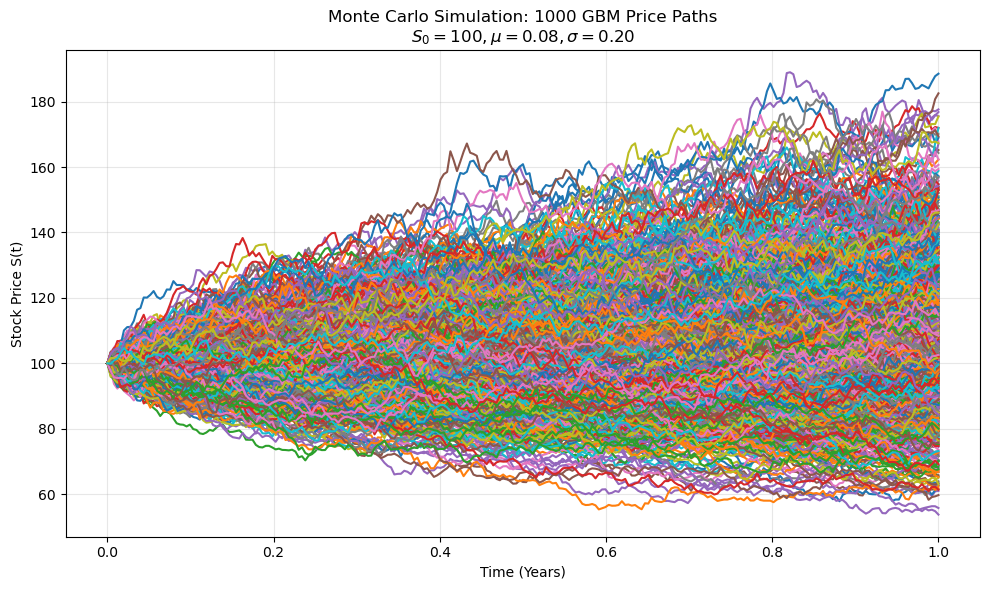

In [5]:
# Plot all simulated price paths
plt.figure(figsize=(10, 6))
plt.plot(tt, St)
plt.xlabel("Time (Years)")
plt.ylabel("Stock Price S(t)")
plt.title(r"Monte Carlo Simulation: 1000 GBM Price Paths" + "\n" +
          r"$S_0 = 100, \mu = 0.08, \sigma = 0.20$")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Analysis: Distribution of Final Prices

### Step 3: Extract Final Prices and Create Histogram

We examine the distribution of stock prices at maturity (t = T). This distribution should approximately follow a lognormal distribution.

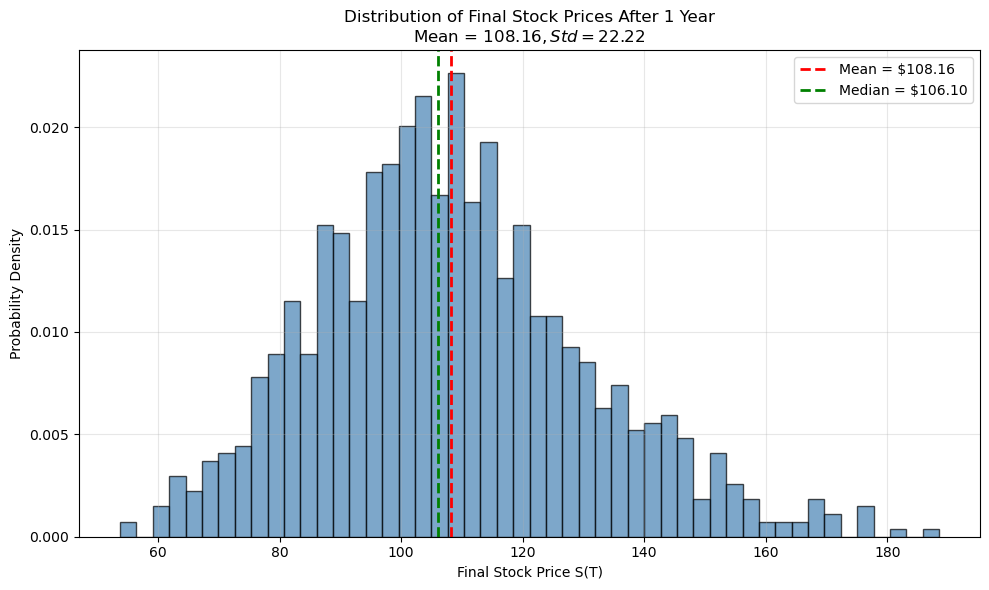

In [6]:
# Extract final prices (last row of St, i.e., prices at t=T)
final_prices = St[-1, :]

# Create histogram of final prices
plt.figure(figsize=(10, 6))
n_bins = 50
counts, bins, patches = plt.hist(final_prices, bins=n_bins, density=True,
                                 alpha=0.7, edgecolor='black', color='steelblue')

plt.xlabel("Final Stock Price S(T)")
plt.ylabel("Probability Density")
plt.title("Distribution of Final Stock Prices After 1 Year\n" +
          f"Mean = ${final_prices.mean():.2f}, Std = ${final_prices.std():.2f}")
plt.axvline(final_prices.mean(), color='red', linestyle='--', linewidth=2,
            label=f"Mean = ${final_prices.mean():.2f}")
plt.axvline(np.median(final_prices), color='green', linestyle='--', linewidth=2,
            label=f"Median = ${np.median(final_prices):.2f}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## European Call Option Valuation

### Step 4: Calculate Option Payoffs

Using the Monte Carlo principle, we estimate the value of a European call option with strike price $K = \$105$ by averaging the payoffs across all simulated paths.

The payoff function is: $\text{Payoff} = \max(S_T - K, 0)$

In [7]:
# Strike price for the European call option
K = 105

# Calculate payoff for each path: max(S_T - K, 0)
payoffs = np.maximum(final_prices - K, 0)

# Estimate option price as the average payoff across all paths
call_option_price = np.mean(payoffs)
call_option_std = np.std(payoffs) / np.sqrt(M)  # Standard error

print(f"European Call Option Valuation")
print(f"="*50)
print(f"Strike Price K: ${K:.2f}")
print(f"Estimated Call Price: ${call_option_price:.4f}")
print(f"Standard Error: ${call_option_std:.4f}")
print(f"95% CI: [${call_option_price - 1.96*call_option_std:.4f}, "
      f"${call_option_price + 1.96*call_option_std:.4f}]")
print(f"\nProbability that option expires ITM: {(payoffs > 0).sum() / M * 100:.2f}%")

European Call Option Valuation
Strike Price K: $105.00
Estimated Call Price: $10.2888
Standard Error: $0.4815
95% CI: [$9.3451, $11.2325]

Probability that option expires ITM: 52.60%


## Statistical Validation

### Step 5: Compare Simulated vs Theoretical Statistics

We validate our simulation by comparing the empirical statistics from our Monte Carlo simulation against the theoretical values derived from the GBM model.

In [8]:
# Theoretical statistics
theo_mean = S0 * np.exp(mu * T)
theo_std = S0 * np.exp(mu * T) * np.sqrt(np.exp(sigma**2 * T) - 1)

# Simulated statistics
sim_mean = np.mean(final_prices)
sim_std = np.std(final_prices, ddof=1)  # Using sample std

# Comparison table
print(f"\nStatistical Validation: GBM Simulation vs Theory")
print(f"="*80)
print(f"{'Metric':<25} {'Theoretical':>15} {'Simulated':>15} {'Abs Error':>15}")
print(f"-"*80)

metrics = [
    ('Mean Final Price', theo_mean, sim_mean),
    ('Std Final Price', theo_std, sim_std),
]

for name, theo_val, sim_val in metrics:
    abs_error = abs(sim_val - theo_val)
    pct_error = (abs_error / abs(theo_val) * 100) if theo_val != 0 else 0
    print(f"{name:<25} ${theo_val:>14.2f} ${sim_val:>14.2f} {pct_error:>14.2f}%")

print(f"-"*80)
print(f"\nNumber of simulations: {M}")
print(f"Time steps per simulation: {n}")
print(f"Total simulation paths: {M * n:,}")


Statistical Validation: GBM Simulation vs Theory
Metric                        Theoretical       Simulated       Abs Error
--------------------------------------------------------------------------------
Mean Final Price          $        108.33 $        108.16           0.16%
Std Final Price           $         21.88 $         22.24           1.61%
--------------------------------------------------------------------------------

Number of simulations: 1000
Time steps per simulation: 252
Total simulation paths: 252,000


## Conclusion and Insights

1. **Convergence**: As the number of simulations increases, simulated statistics converge to theoretical values
2. **Risk Profile**: The distribution of final prices is lognormal, reflecting realistic stock behavior
3. **Option Valuation**: Monte Carlo provides a flexible framework for pricing complex derivatives
4. **Scalability**: The method easily extends to multiple assets and path-dependent options

---